# Data sources
The dataset can be found on [Kaggle](https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification) site.

# 1: Setup Kaggle API for data download

# 1.1: Install / Update Kaggle library

In [1]:
!pip install -q kaggle

# 1.2: Upload Kaggle JSON file

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hahalim","key":"ce68a07f66f1bdfcaa4088307943d0e2"}'}

# 1.3: Create hidden folder at root directory and transfer the json file to the folder

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

# 1.4: Change the access permission

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

# 1.5: Test the kaggle API

In [5]:
!kaggle datasets list

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muhammadehsan000/global-electric-vehicle-sales-data-2010-2024   Global Electric Vehicle Sales Data (2010-2024)      83KB  2024-08-09 16:39:22           1289         23  1.0              
myrios/cost-of-living-index-by-country-by-number-2024           Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           4317         63  1.0              
abdallahwagih/company-employees                                 Company Employees                                   68KB  2024-08-10 12:13:08           1157         30  0.8235294        
waqi786/heart-attack-dataset                                    ❤

# 1.6: Download the zipped dataset

In [6]:
!kaggle datasets download -d samuelcortinhas/sports-balls-multiclass-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification
License(s): CC0-1.0
 99% 398M/401M [00:07<00:00, 51.4MB/s]
100% 401M/401M [00:07<00:00, 53.8MB/s]


# 2: Data loading & preprocessing
## 2. 1: Unzip the compressed files

In [7]:
!unzip -q sports-balls-multiclass-image-classification.zip

The above bash command will spawn `train` and `test` folders with subfolders of different types of sports balls.

## 2.2: Make use of Keras API to get `tf.data.Dataset`

In [8]:
# setup
import tensorflow as tf
from tensorflow import keras
import pathlib
import matplotlib.pyplot as plt

In [9]:
train_data_dir = pathlib.Path("./train")
test_data_dir = pathlib.Path("./test")

In [10]:
list(train_data_dir.glob("*/*.jpg"))[:10]

[PosixPath('train/american_football/american_football_295.jpg'),
 PosixPath('train/american_football/american_football_51.jpg'),
 PosixPath('train/american_football/american_football_526.jpg'),
 PosixPath('train/american_football/american_football_298.jpg'),
 PosixPath('train/american_football/american_football_131.jpg'),
 PosixPath('train/american_football/american_football_207.jpg'),
 PosixPath('train/american_football/american_football_16.jpg'),
 PosixPath('train/american_football/american_football_640.jpg'),
 PosixPath('train/american_football/american_football_534.jpg'),
 PosixPath('train/american_football/american_football_25.jpg')]

In [10]:
print("Number of training images:", len(list(train_data_dir.glob("*/*.jpg"))))
print("Number of test images:", len(list(test_data_dir.glob("*/*.jpg"))))

Number of training images: 7328
Number of test images: 1841


### Create the dataset

In [11]:
BATCH_SIZE = 64
IMG_SIZE = (192, 192)

train_ds = keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=987
)

val_ds = keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=987
)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.
Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [12]:
test_ds = keras.utils.image_dataset_from_directory(
    test_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1841 files belonging to 15 classes.


### Visualize training dataset

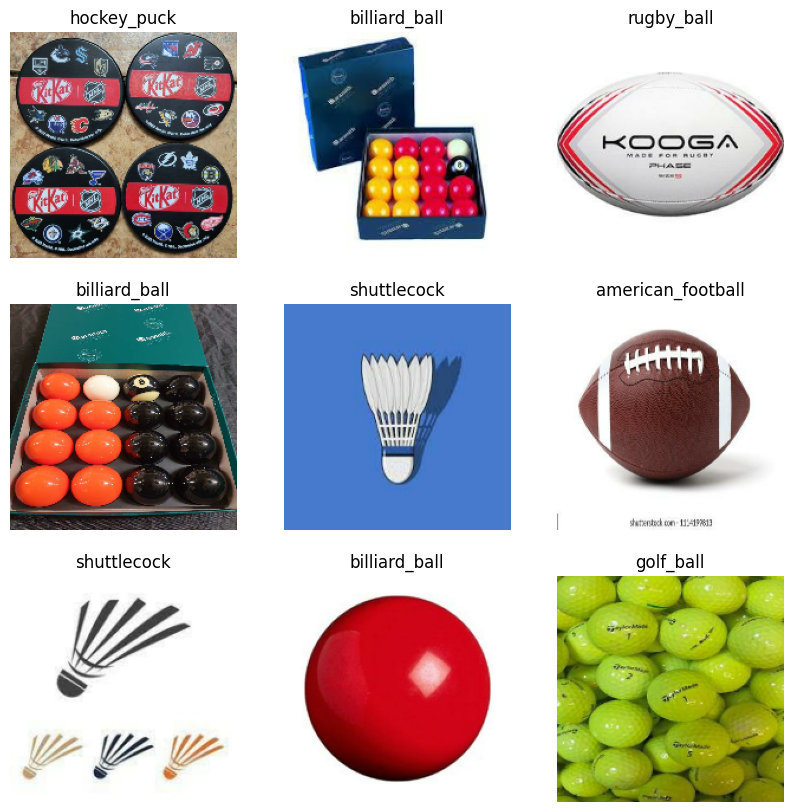

In [13]:
import numpy as np
class_names = train_ds.class_names

# show images in 3x3 grid
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

### Show the train dataset shapes (debugging)

In [14]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(64, 192, 192, 3)
(64,)


### Extra: find out the number of batches for different subsets of data

In [15]:
print("Number of training batches:", tf.data.experimental.cardinality(train_ds))
print("Number of validation batches:", tf.data.experimental.cardinality(val_ds))
print("Number of test batches:", tf.data.experimental.cardinality(test_ds))

Number of training batches: tf.Tensor(92, shape=(), dtype=int64)
Number of validation batches: tf.Tensor(23, shape=(), dtype=int64)
Number of test batches: tf.Tensor(29, shape=(), dtype=int64)


### Configure the data for better performance

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [17]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation((-0.1, 0.1)),
    layers.RandomZoom((-0.2, 0.2))
])

### Visualize the augmentation

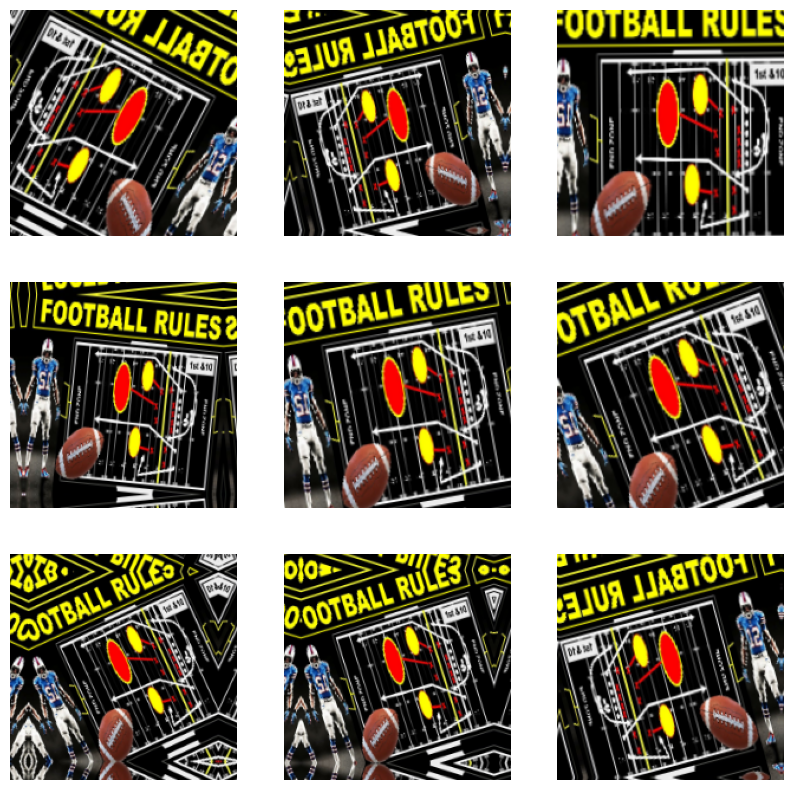

In [18]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        plt.subplot(3, 3, i+1)
        augmented = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented[0].numpy().astype(np.uint8))
        plt.axis("off")

plt.show()

# 3 Pretrained model: ResNet50
ResNet50

In [19]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [20]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights="imagenet")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# freeze the convolutional base
base_model.trainable = False

In [31]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 198, 198, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 96, 96, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 96, 96, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 96, 96, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 98, 98, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 48, 48, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 48, 48, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 48, 48, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 48, 48, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 48, 48, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## 3.2 Construct the model

In [22]:
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(len(class_names), activation="sigmoid")(x)
model = keras.Model(inputs, output)

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 192, 192, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 192, 192)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 192, 192)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 192, 192)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 192, 192, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 192, 192, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 6, 6, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 15)             │         30,735 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,618,447 (90.10 MB)

 Trainable params: 30,735 (120.06 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

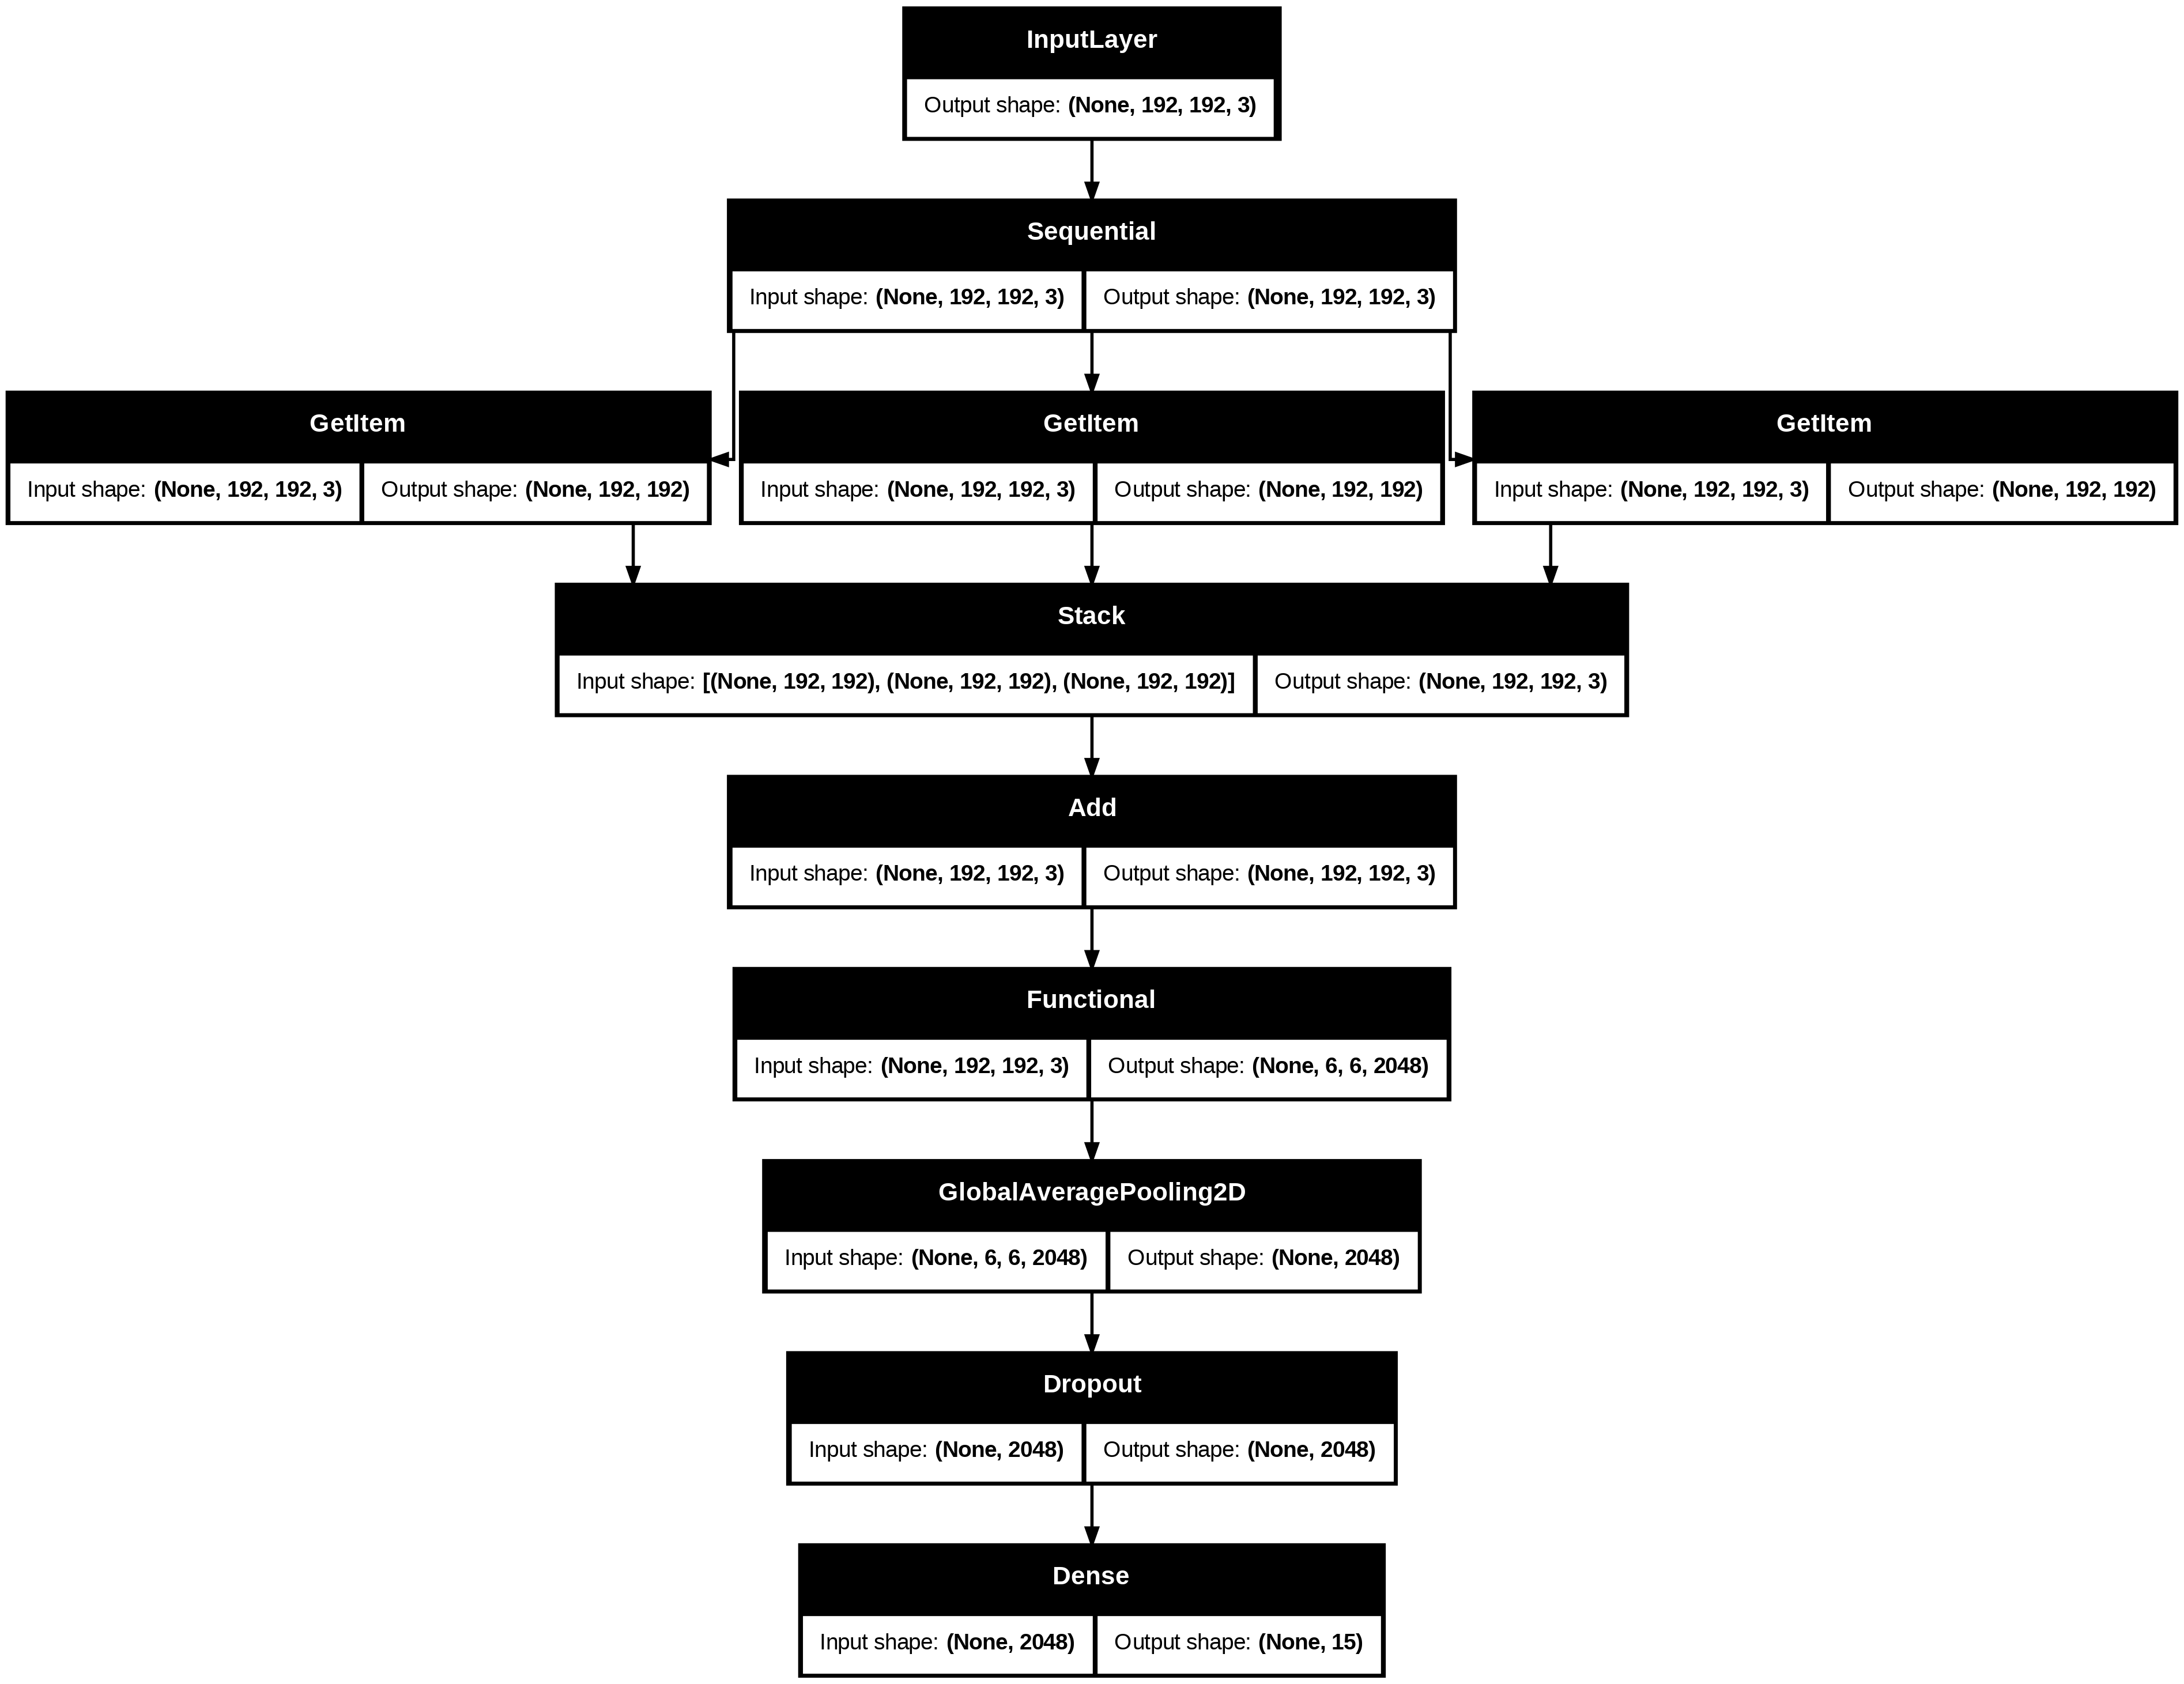

In [24]:
from keras.utils import plot_model

plot_model(model, to_file="ResNet50_classifier.png", show_shapes=True)

## 3.3 Compile the model

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# 4: Train the model

In [26]:
epochs = 20

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 370ms/step - accuracy: 0.4011 - loss: 2.0471 - val_accuracy: 0.7563 - val_loss: 0.7919
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.7362 - loss: 0.8286 - val_accuracy: 0.7823 - val_loss: 0.6962
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 243ms/step - accuracy: 0.7881 - loss: 0.6427 - val_accuracy: 0.8000 - val_loss: 0.6723
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.8141 - loss: 0.5757 - val_accuracy: 0.8239 - val_loss: 0.6056
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.8321 - loss: 0.5084 - val_accuracy: 0.8184 - val_loss: 0.6165
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.8483 - loss: 0.4721 - val_accuracy: 0.8314 - val_loss: 0.5810
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.8600 - loss: 0.4289 - val_accuracy: 0.8287 - val_loss: 0.5879
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.8667 - loss: 0.4029 - val_accu

##4.1: Plot learning curve

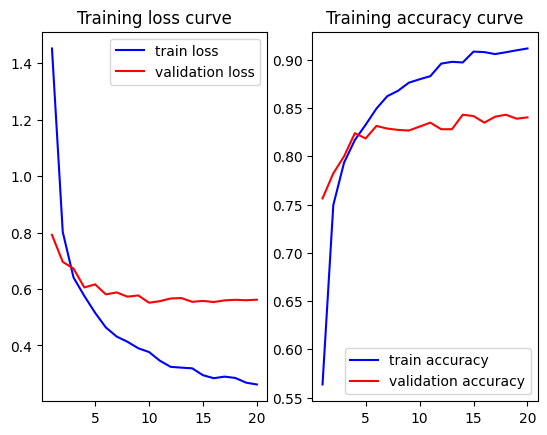

In [27]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# len(loss)
plt.subplot(121)
plt.plot(range(1, len(loss)+1), loss, "b-", label="train loss")
plt.plot(range(1, len(val_loss)+1), val_loss, "r-", label="validation loss")
plt.legend()
plt.title("Training loss curve")

plt.subplot(122)
plt.plot(range(1, len(acc)+1), acc, "b-", label="train accuracy")
plt.plot(range(1, len(val_acc)+1), val_acc, "r-", label="validation accuracy")
plt.legend()
plt.title("Training accuracy curve")

plt.show()

##4.2 Save the model

In [28]:
model.save("ResNet50_classifier.keras")

##5: Model evaluation

In [29]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", round(test_acc, 4))

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.8463 - loss: 0.6470
Test accuracy: 0.8349


##5.1 Prediction

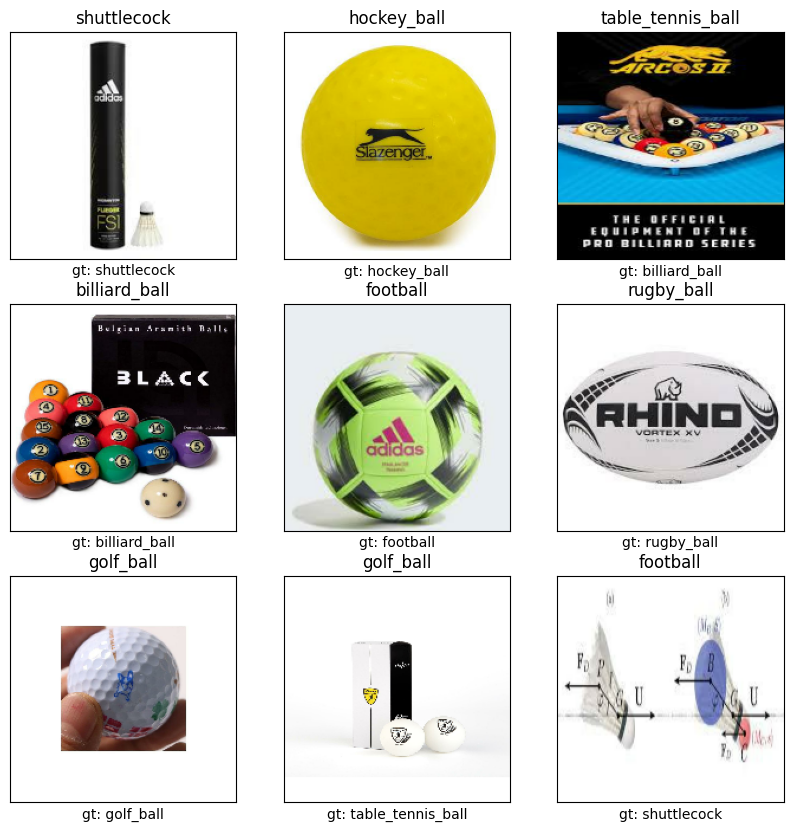

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
pred_classes = np.argmax(predictions, axis=-1)

# post-process the predictions and visualize
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[pred_classes[i]])
    plt.xlabel(f"gt: {class_names[label_batch[i]]}")
    plt.xticks([]), plt.yticks([])

In [32]:
predictions.shape

(64, 15)

In [33]:
class_names

['american_football',
 'baseball',
 'basketball',
 'billiard_ball',
 'bowling_ball',
 'cricket_ball',
 'football',
 'golf_ball',
 'hockey_ball',
 'hockey_puck',
 'rugby_ball',
 'shuttlecock',
 'table_tennis_ball',
 'tennis_ball',
 'volleyball']